# Guided Project: Predicting House Sale Prices
### Import libraries:

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Read file and examing the file:

In [48]:
housing = pd.read_csv('AmesHousing.tsv',sep='\t')
housing.dtypes

Order                int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
B

There are total 3 types of data in this dataframe:
- int64
- object
- float64

int64 and float64 are numbers and object is the text.

### Data Training:

In [49]:
def transform_features(df):
    return df

In [50]:
def select_features(df): 
    return df[['Gr Liv Area','SalePrice']]

In [51]:
def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
        
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = train.select_dtypes(include=['integer','float'])
    feature_col = numeric_train.columns.drop("SalePrice")
    
    lr = LinearRegression()
    lr.fit(train[feature_col],train['SalePrice'])
    test_prediction = lr.predict(test[feature_col])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'],test_prediction))
    return rmse

In [52]:
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

57088.25161263909

### Feature engineering:
- Handle missing values:
    - All columns:
        - Drop any with 5% or more missing values for now.
    - Text columns:
        - Drop any with 1 or more missing values for now.
    - Numerical columns:
        - For columns with missing values, fill in with the most common value in that column

#### 1: All columns: Drop any with 5% or more missing values for now.

In [53]:
# Checking totall null value in dataframe
num_missing = housing.isnull().sum()

In [54]:
# Filter Series to columns containing >5% missing values
drop_missing_cols = num_missing[(num_missing > len(housing)/20)].sort_values()
# Drop those columns from the data frame. Note the use of the .index accessor
df = housing.drop(drop_missing_cols.index, axis=1)
drop_missing_cols

Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Qual       159
Garage Cond       159
Lot Frontage      490
Fireplace Qu     1422
Fence            2358
Alley            2732
Misc Feature     2824
Pool QC          2917
dtype: int64

#### 2: Drop any with 1 or more missing values for now.

In [55]:
## Series object: column name -> number of missing values
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

## Filter Series to columns containing *any* missing values
drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]

df = df.drop(drop_missing_cols_2.index, axis=1)
drop_missing_cols_2

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
dtype: int64

#### 3: For columns with missing values, fill in with the most common value in that column

In [56]:
## Compute column-wise missing value counts
num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [57]:
## Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [58]:
df = df.fillna(replacement_values_dict)

#### 4: Create new features:
- Years Since Remod
- Years Before Sale

In [59]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [60]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [61]:
## Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

#### 5: Find columns that need to be dropped:

In [62]:
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition', 'SalePrice', 'Years Before Sale', 'Years Since Remod'], dtype='object')

In [63]:
columns_not_useful = ['Order','PID']
columns_leaks = ['Mo Sold','Yr Sold','Sale Condition','Sale Type']

df = df.drop(columns_not_useful, axis = 1)
df = df.drop(columns_leaks, axis = 1)

#### 6: Combines above features into function:

In [64]:
def transform_features(df):
    #1: All columns: Drop any with 5% or more missing values for now.
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    #2: Drop any with 1 or more missing values for now.
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    #3: For columns with missing values, fill in with the most common value in that column
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    df = df.fillna(replacement_values_dict)
    
    #4: Create new features:
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    years_since_remod[years_since_remod < 0]
    years_sold = df['Yr Sold'] - df['Year Built']
    years_sold[years_sold < 0]
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    #5: Find columns that need to be dropped:
    columns_not_useful = ['Order','PID']
    columns_leaks = ['Mo Sold','Yr Sold','Sale Condition','Sale Type']
    df = df.drop(columns_not_useful, axis = 1)
    df = df.drop(columns_leaks, axis = 1)
    return df

def select_features(df): 
    return df[['Gr Liv Area','SalePrice']]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
        
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = train.select_dtypes(include=['integer','float'])
    feature_col = numeric_train.columns.drop("SalePrice")
    
    lr = LinearRegression()
    lr.fit(train[feature_col],train['SalePrice'])
    test_prediction = lr.predict(test[feature_col])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'],test_prediction))
    return rmse

df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

55275.36731241307


## Feature selection:

#### 1: Determine the correlation:

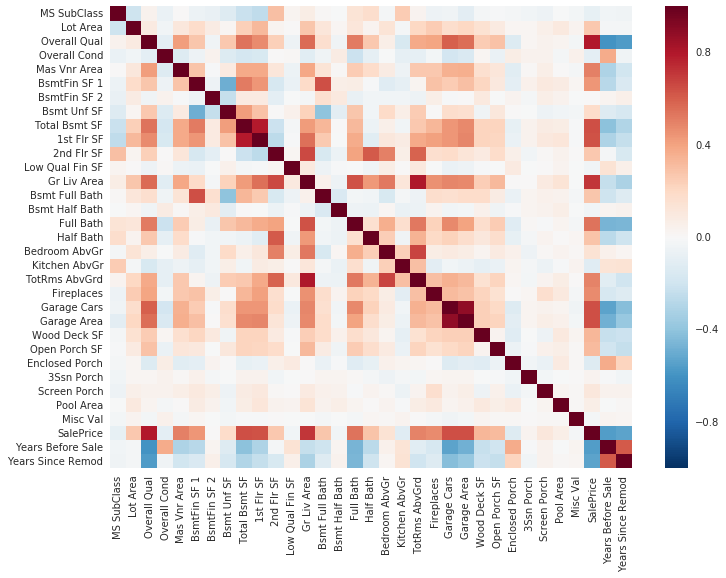

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
corr_df = transform_features(df).corr()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.heatmap(corr_df)

Select the the correlation value thats greater than 0.4:

In [66]:
transform_df = transform_features(df)
numerical_df = transform_df.select_dtypes(include=['int', 'float'])

abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

In [67]:
abs_corr_coeffs[abs_corr_coeffs > 0.4]

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [68]:
## Drop columns with less than 0.4 correlation with SalePrice
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)

#### 2: Determine the column needs to be convert to categorical data:

In [69]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
df = transform_features(df)
df.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice', 'Years Before Sale', 'Years Since Remod'], dtype='object')

All of the columns that can be categorized as nominal variables are candidates for being converted to categorical.

In [70]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

#### 3: Checking number of unique value and low variance data:

In [71]:
## Which categorical columns have we still carried with us? We'll test tehse 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

## How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
## Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

In [72]:

## Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1)

#### 4: update above to select_features function:

In [73]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
        
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

In [74]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

33367.28718340324

### Trainning and testing model parameter control:

In [75]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

#### k = 0

In [83]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=0)
rmse

33367.28718340324

#### k = 1

In [84]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=1)
rmse

33367.28718340324
27155.13848482559


30261.212834114416

#### k = 2

In [85]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=2)
rmse

[31564.686481292887, 27965.463498058045]


29765.074989675464

 #### k = 3

In [86]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=3)
rmse

[26917.934182310837, 25569.112445114904, 36001.38058983236]


29496.142405752704

#### k = 4

In [87]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=4)
rmse

[26125.475719141396, 37217.0382736774, 25731.414253922292, 26033.181437192998]


28776.77742098352

#### k = 5

In [88]:
df = pd.read_csv('AmesHousing.tsv',delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=5)
rmse

[25246.492601601425, 31162.40800556449, 26262.687631834615, 25117.458089721196, 37147.357184741784]


28987.2807026927

RMSE tends to be smaller when k is around 4.
This project guid me to succussfully reduce the orginal rmse of 57088 to 28776. 
Reduced error nearly half from the orginal value.